# A Study on the Robustness of CAPTCHA Recognition Models Against Various Types of Noise

**Authors:** Yann Gautier, Noé Idesheim, Titouan Constance

---

## 1. Introduction and Problem Statement

CAPTCHAs remain a standard for web security. While modern Deep Learning models (CNNs) solve them with ease on clean images, their reliability diminishes when the image is degraded.

**The central question of this project is as follows:**
> *How does image alteration via the injection of different noise types impact the resolution of CAPTCHAs by recognition models?*

We will focus on:
1.  The generation of a **synthetic CAPTCHA dataset** (based on MNIST).
2.  The training of a **Multi-Head CNN** capable of recognizing 4 digits simultaneously.
3.  The evaluation of **robustness** against two noise types (Gaussian, Salt & Pepper).

### Technical Environment
To set up the necessary environment for this project, please refer to the project's `README.md` file.

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 

# Configuration for Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Display Configuration
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_theme(style="whitegrid")

## 2. Data Pipeline: Construction of a CAPTCHA Dataset

Our data generation strategy relies on the assembly of handwritten digits derived from the MNIST dataset.

### Generation Process
1.  **Individual Pre-processing**: Each MNIST digit (28x28) is converted, rendering the black background transparent (Alpha channel).
2.  **Assembly & Transformations**: 4 digits are arranged side-by-side with random variations:
    * **Rotation** (slight).
    * **Scaling**.
3.  **Formatting**: The ensemble is placed on a unified black background and resized to **100x110 pixels**.

To mitigate **overfitting** (preventing the model from memorizing noisy images), noise is not stored permanently. Instead, it is injected dynamically **on-the-fly** during each training or prediction batch.

In [ ]:
from MNIST import MnistDataloader 
import matplotlib.pyplot as plt
import numpy as np

loader = MnistDataloader(data_dir='..\data')

loader.download_mnist()

loader.show_images(num_train=3, num_test=2, seed=42)

loader.create_captcha_dataset(num_train=100_000, num_test=20_000, seed=42)

loader.show_captcha(num_train=3, num_test=2, seed=42)

loader.show_captcha(num_train=3, num_test=2, apply_noise=True, noise_type='salt_and_pepper', noise_factor=0.1, seed=42)


## 3. Modeling: Multi-Head CNN Architecture

To address the problem of CAPTCHA reading, we selected a **Multi-Head CNN** (Convolutional Neural Network) architecture.

### Rationale for this Architecture
Classical methods often require slicing the image to isolate each character (segmentation) before recognition. With the introduction of noise, this segmentation becomes unreliable.
Our approach takes the **entire** image as input and features **4 independent output heads**, each learning to predict the digit at a specific position (1st, 2nd, 3rd, 4th).

### Architecture Overview
The architecture shares a common feature extraction backbone (convolutional layers) for all digits, before branching out.

![Multi-Head CNN Architecture Diagram](..\ressources\multi_head_ccn_schema.png)

In [ ]:
from src import multi_head_CNN 
import tensorflow as tf
import os

MODEL_PATH = os.path.join('..', 'data', 'models', 'multi_output_cnn.keras')

multi_head_CNN.train_and_evaluate(
        model_save_path=MODEL_PATH,
        apply_noise=True, 
        noise_type='salt_and_pepper', 
        noise_factor=0.2, 
        noise_factor_end=0.4, 
        noise_step=0.1,
        rgb_noise=False
    )

## 4. Baseline: OCR API

To benchmark the effectiveness of our specialized model, we compare it against an off-the-shelf solution: the **OCR.space** API.

> **Note**: Preliminary tests indicate that general-purpose OCR solutions (optimized for scanned documents) fail rapidly on our CAPTCHAs, even at very low (or zero) noise levels. Consequently, we restrict the noise factor here to **0.1** to maintain a feasible evaluation scope for the API.

Ensure that a `.env` file exists in the `src` directory containing your key: `OCR_api_KEY=...`.

Loading 2 training images (sequential)...
Loading 0 test images (sequential)...
CAPTCHA dataset loaded successfully!
Applying gaussian noise (grayscale mode) to CAPTCHA images (factor: 0.1)...
Prédiction de l'image 0...


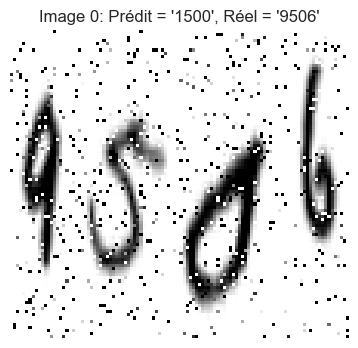

Prédiction de l'image 1...


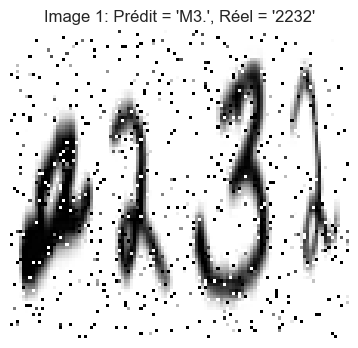


--- Résumé des prédictions OCR ---
Image 0: Prédit = '1500', Réel = '9506'
Image 1: Prédit = 'M3.', Réel = '2232'


In [ ]:
import os
from dotenv import load_dotenv
from OCR_api import test_ocr_on_captcha

# Load configuration
load_dotenv(dotenv_path=os.path.join(".env")) 
api_key = os.getenv("OCR_API_KEY")

if api_key is None:
    print(" Error: API Key not found. Please verify that 'OCR_API_KEY' is present in 'src/.env'")
else:  

    h5_filepath = os.path.join('..','data', 'captcha_data', 'captcha_dataset.h5')
    
    if os.path.exists(h5_filepath):
        # OCR testing on CAPTCHAs with low noise intensity
        results = test_ocr_on_captcha(
            mnist_loader=loader,
            api_key=api_key,
            h5_filepath=h5_filepath,
            num_images=2,       # Limiting to 3 requests to avoid spamming the API
            noise_factor=0.1,   # Low noise level as the OCR is highly sensitive
            display_images=True
        )
        
        # Display text summary
        print("\n--- OCR Predictions Summary ---")
        for r in results:
            clean_pred = r['predicted'].replace(" ", "").replace("\n", "")
            print(f"Image {r['index']}: Predicted = '{clean_pred}', Ground Truth = '{r['true_label']}'")
    else:
        print(f"The file {h5_filepath} does not exist. Please execute the dataset generation (Previous Cell).")

## 5. Statistical Analysis and Robustness

In this section, we evaluate the robustness of our model and the OCR API against different levels and types of noise. The objectives are multiple:
- Quantify performance degradation as a function of noise.
- Compare the resilience of our specialized model to that of the general-purpose OCR API.
- Determine if combining both approaches can enhance recognition.
- Identify the CAPTCHAs that are most challenging for these models to recognize.

### 5.1 Creation of an Evaluation Dataset
Initially, we will generate an evaluation dataset based on the different models by varying the type and level of noise applied to the images.

We will:
1.  Vary the noise intensity from **0.0 (clean)** to **0.5 (highly noisy)**.
2.  Test two types of noise: **Gaussian** and **Salt & Pepper**.
3.  Store these results in a **Pandas DataFrame** for analysis.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from MNIST import MnistDataloader
from multi_head_CNN import apply_balanced_noise
import os

# Load CAPTCHA dataset
data_dir = '..\data'
mnist_loader = MnistDataloader(data_dir=data_dir)
h5_filepath = os.path.join(data_dir, 'captcha_data', 'captcha_dataset.h5')
(x_train, y_train), (x_test, y_test) = mnist_loader.load_captcha_dataset(h5_filepath=h5_filepath, num_images_test=100)
# Limit to 100 test images for demo
# Load the model
model_path = os.path.join(data_dir, 'models', 'multi_output_cnn.keras')
model = tf.keras.models.load_model(model_path)
# Prepare data for CSV
data_rows = []

for idx, (image, true_solution) in enumerate(zip(x_test, y_test)):
    # Determine image format
    if len(image.shape) == 3 and image.shape[-1] == 1:  # Grayscale
        image_format = 0
        image_data = image.astype(int)  # numpy array of ints 0-255
    elif len(image.shape) == 3 and image.shape[-1] == 3:  # RGB
        image_format = 1
        image_data = image.astype(int)  # 3D array (H, W, C)
    else:
        continue  # Skip if not matching
    
    solution = ''.join(map(str, true_solution))  # Convert list to string
    
    # First, add the no-noise case
    noisy_image = image
    # Preprocess for model
    if image_format == 0:  # Grayscale
        image_gray = noisy_image
    else:  # RGB
        image_gray = np.mean(noisy_image, axis=-1, keepdims=True)
    image_normalized = image_gray.astype('float32') / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)
    
    # Predict
    predictions = model.predict(image_batch, verbose=0)
    predicted_digits = [int(np.argmax(pred[0])) for pred in predictions]
    response = ''.join(map(str, predicted_digits))
    
    # Add row for no noise
    data_rows.append({
        'id': idx,
        'image_format': image_format,
        'image_data': image_data,  # numpy array
        'solution': solution,
        'noise': 0,
        'noise_type': 'none',
        'noise_factor': 0.0,
        'response': response
    })
    
    # Now, for each noise type, generate balanced noise from 0.3 to 1.0
    for noise_type in ['gaussian', 'salt_and_pepper']:
        # Generate noise levels uniformly from 0.3 to 1.0 with step 0.1
        noise_levels = []
        current = 0.3
        while current <= 1.0 + 1e-9:
            noise_levels.append(round(current, 5))
            current += 0.1
        num_levels = len(noise_levels)
        
        # Repeat the image num_levels times
        images_batch = [image] * num_levels
        
        # Apply balanced noise using the function from multi_head_CNN
        noisy_images = apply_balanced_noise(images_batch, noise_type, 0.3, 1.0, 0.1, rgb_noise=(image_format == 1))
        
        # For each noisy image and corresponding level
        for noisy_image, level in zip(noisy_images, noise_levels):
            # Preprocess for model
            if image_format == 0:  # Grayscale
                image_gray = noisy_image
            else:  # RGB
                image_gray = np.mean(noisy_image, axis=-1, keepdims=True)
            image_normalized = image_gray.astype('float32') / 255.0
            image_batch = np.expand_dims(image_normalized, axis=0)
            
            # Predict
            predictions = model.predict(image_batch, verbose=0)
            predicted_digits = [int(np.argmax(pred[0])) for pred in predictions]
            response = ''.join(map(str, predicted_digits))
            
            # Add row
            data_rows.append({
                'id': idx,
                'image_format': image_format,
                'image_data': image_data,  # numpy array
                'solution': solution,
                'noise': 1,
                'noise_type': noise_type,
                'noise_factor': level,
                'model_response': response
            })
# Create DataFrame
df = pd.DataFrame(data_rows)

# Save to CSV (note: numpy arrays will be stored as strings; for full arrays, consider HDF5 or pickle)
df.to_csv('data\captcha_evaluation.csv', index=False)
print("CSV file 'captcha_evaluation.csv' created successfully.")

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:106: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:106: SyntaxWarning: invalid escape sequence '\c'
C:\Users\admin\AppData\Local\Temp\ipykernel_19820\651831626.py:9: SyntaxWarning: invalid escape sequence '\d'
  data_dir = '..\data'
C:\Users\admin\AppData\Local\Temp\ipykernel_19820\651831626.py:15: SyntaxWarning: invalid escape sequence '\d'
  model_path = '..\data/models/multi_output_cnn.keras'
C:\Users\admin\AppData\Local\Temp\ipykernel_19820\651831626.py:106: SyntaxWarning: invalid escape sequence '\c'
  df.to_csv('data\captcha_evaluation.csv', index=False)


Loading all training data (100000 images)...
Loading 100 test images (sequential)...
CAPTCHA dataset loaded successfully!
Applying gaussian noise with 8 levels: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Level 0.30: processing 1 images (1-1)
  Level 0.40: processing 1 images (2-2)
  Level 0.50: processing 1 images (3-3)
  Level 0.60: processing 1 images (4-4)
  Level 0.70: processing 1 images (5-5)
  Level 0.80: processing 1 images (6-6)
  Level 0.90: processing 1 images (7-7)
  Level 1.00: processing 1 images (8-8)
Applying salt_and_pepper noise with 8 levels: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Level 0.30: processing 1 images (1-1)
  Level 0.40: processing 1 images (2-2)
  Level 0.50: processing 1 images (3-3)
  Level 0.60: processing 1 images (4-4)
  Level 0.70: processing 1 images (5-5)
  Level 0.80: processing 1 images (6-6)
  Level 0.90: processing 1 images (7-7)
  Level 1.00: processing 1 images (8-8)
Applying gaussian noise with 8 levels: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0

In [129]:
#We add some prediction of OCR API
import random
from OCR_api import ocr_space_one_image
from dotenv import load_dotenv
df["OCR_response"] = np.nan

indexes = random.sample(range(df["id"].max()), k=10)  # Select 10 random indexes for OCR predictions
print(indexes)

load_dotenv(dotenv_path=".env") 
api_key = os.getenv("OCR_API_KEY")
for idx in indexes:
    image_data = df[df["id"]==idx]["image_data"].values[0]
    text=ocr_space_one_image(image_data=image_data, api_key=api_key)
    df.loc[df["id"]==idx, "OCR_response"] = text

[15, 14, 89, 24, 82, 45, 79, 47, 67, 75]
Prédiction de l'image...
{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is not requested'}, 'TextOrientation': '0', 'FileParseExitCode': 1, 'ParsedText': '862г', 'ErrorMessage': '', 'ErrorDetails': ''}], 'OCRExitCode': 1, 'IsErroredOnProcessing': False, 'ProcessingTimeInMilliseconds': '953', 'SearchablePDFURL': 'Searchable PDF not generated as it was not requested.'}
Prédiction de l'image...


C:\Users\admin\AppData\Local\Temp\ipykernel_19820\781620194.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '862г' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df["id"]==idx, "OCR_response"] = text


{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is not requested'}, 'TextOrientation': '0', 'FileParseExitCode': 1, 'ParsedText': '>606', 'ErrorMessage': '', 'ErrorDetails': ''}], 'OCRExitCode': 1, 'IsErroredOnProcessing': False, 'ProcessingTimeInMilliseconds': '625', 'SearchablePDFURL': 'Searchable PDF not generated as it was not requested.'}
Prédiction de l'image...
{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is not requested'}, 'TextOrientation': '0', 'FileParseExitCode': 1, 'ParsedText': '3493', 'ErrorMessage': '', 'ErrorDetails': ''}], 'OCRExitCode': 1, 'IsErroredOnProcessing': False, 'ProcessingTimeInMilliseconds': '640', 'SearchablePDFURL': 'Searchable PDF not generated as it was not requested.'}
Prédiction de l'image...
{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is 

In [ ]:
df['correct'] = df.apply(
    lambda row: int(all(a == b for a, b in zip(row['solution'], row['model_response']))),
    axis=1
)
# Compute the number of correct digits for each prediction
df['n_correct_digits'] = df.apply(
    lambda row: sum(1 for a, b in zip(row['solution'], row['model_response']) if a == b), 
    axis=1
)

# Evaluate each digit independently
for digit_pos in range(4):
    df[f'correct_digit_{digit_pos}'] = df.apply(
        lambda row: int(row['solution'][digit_pos] == row['model_response'][digit_pos]),
        axis=1
    )

### 5.2 Global Performance Analysis of the CNN Model

### 5.3 Performance Comparison between the CNN Model and the OCR API

### 5.4 Study of the Hybrid Approach

### 5.5 Identification of the Most Challenging CAPTCHAs to Recognize